In [1]:
v = 12 % 16 + 1 # считаем вариант
print(f"Вариант №{v}")

Вариант №13


Spark

Подключаем необходимые библиотеки

In [2]:
import re # регулярные выражения
import sqlite3 # использование базы данных SQLite
import pandas as pd # работа с табличными данными
import matplotlib.pyplot as plt # визуализация данных
import seaborn as sns
import os.path # для скачивания логов

Скачиваем логи

In [3]:
if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 575 (delta 145), reused 136 (delta 132), pack-reused 404 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (267/267), done.


Просматриваем примеры логов по варианту

In [4]:
for i in open('./loghub/Spark/Spark_2k.log', 'r', encoding='utf-8').readlines()[:5]:
  print(i)

17/06/09 20:10:40 INFO executor.CoarseGrainedExecutorBackend: Registered signal handlers for [TERM, HUP, INT]

17/06/09 20:10:40 INFO spark.SecurityManager: Changing view acls to: yarn,curi

17/06/09 20:10:40 INFO spark.SecurityManager: Changing modify acls to: yarn,curi

17/06/09 20:10:40 INFO spark.SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users with view permissions: Set(yarn, curi); users with modify permissions: Set(yarn, curi)

17/06/09 20:10:41 INFO spark.SecurityManager: Changing view acls to: yarn,curi



Создаём и проверяем регулярное выражение для парсинга логов

In [7]:
log_line = open('./loghub/Spark/Spark_2k.log', 'r', encoding='utf-8').readlines()[0]

In [12]:
regex_pattern = r'(\d{2}/\d{2}/\d{2}) (\d{2}:\d{2}:\d{2}) (\w+) (\S+): (.*)'
matches = re.match(regex_pattern, log_line)
if matches:
  date = matches.group(1)
  time = matches.group(2)
  log_level = matches.group(3)
  service = matches.group(4)
  message = matches.group(5)
print("Date:", date)
print("Time:", time)
print("Log Level:", log_level)
print("Service:", service)
print("Message:", message)

Date: 17/06/09
Time: 20:10:40
Log Level: INFO
Service: executor.CoarseGrainedExecutorBackend
Message: Registered signal handlers for [TERM, HUP, INT]


In [15]:
pattern = re.compile(r'(\d{2}/\d{2}/\d{2}) (\d{2}:\d{2}:\d{2}) (\w+) (\S+): (.*)')

Создаём БД

In [13]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")
db_path = './db/log-analysis.db' # путь к файлу БД
connection = sqlite3.connect(db_path) # подключаемся к БД
cursor = connection.cursor() # создание курсора
cursor.execute("DROP TABLE IF EXISTS LogTable") # очистка БД (если существует)
cursor.execute("CREATE TABLE LogTable (id INTEGER PRIMARY KEY AUTOINCREMENT,\
                date DATE, time TIME, level VARCHAR(50),\
                service VARCHAR(255), message TEXT)") # Создаём таблицу с полями логов
connection.commit() # сохраняем изменения
cursor.close() # закрываем курсор
connection.close() # отключаемся от БД

Парсим логи в БД

In [16]:
connection = sqlite3.connect(db_path) # подключаемся к БД
cursor = connection.cursor() # создаём курсор
cursor.execute("DELETE FROM LogTable") # очищаем от дублей
with open('./loghub/Spark/Spark_2k.log', 'r', encoding='utf-8') as log_file: # парсим логи
    for line in log_file:
        log_match = pattern.match(line)
        if log_match:
            date = log_match.group(1)
            time = log_match.group(2)
            level = log_match.group(3)
            service = log_match.group(4)
            message = log_match.group(5)
            values = (date, time, level, service, message) # создаём значение для записи в БД
            sql = "INSERT INTO LogTable (date, time, level, service, message) VALUES (?, ?, ?, ?, ?)"
            cursor.execute(sql, values) # записываем данные в БД
connection.commit()
cursor.close()
connection.close()

Перенесём логи в датафрейм для последующей визуализации и выведем

In [17]:
connection = sqlite3.connect(db_path)
cursor = connection.cursor()
cursor.execute("SELECT * FROM LogTable")
rows = cursor.fetchall()
cursor.close()
connection.close()
log_df = pd.DataFrame(rows, columns=("id", "date", "time", "level", "service", "message")) # создадим датафрейм с записями из БД
log_df.head() # выведем первые несколько значений

,id,date,time,level,service,message
0,1,17/06/09,20:10:40,INFO,executor.CoarseGrainedExecutorBackend,"Registered signal handlers for [TERM, HUP, INT]"
1,2,17/06/09,20:10:40,INFO,spark.SecurityManager,"Changing view acls to: yarn,curi"
2,3,17/06/09,20:10:40,INFO,spark.SecurityManager,"Changing modify acls to: yarn,curi"
3,4,17/06/09,20:10:40,INFO,spark.SecurityManager,SecurityManager: authentication disabled; ui a...
4,5,17/06/09,20:10:41,INFO,spark.SecurityManager,"Changing view acls to: yarn,curi"


Визаулизируем уровни логов

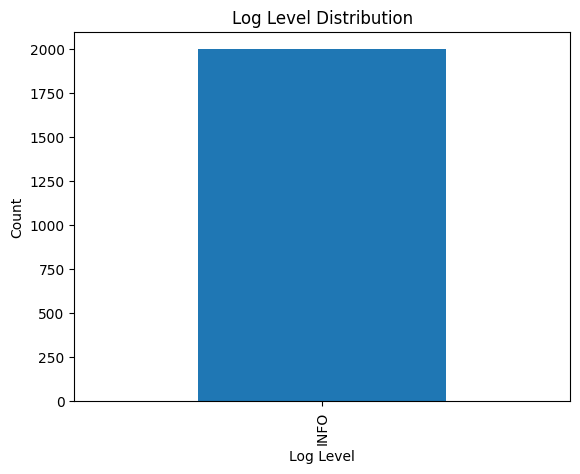

In [18]:
log_level_counts = log_df['level'].value_counts()
log_level_counts.plot(kind='bar')
plt.xlabel('Log Level')
plt.ylabel('Count')
plt.title('Log Level Distribution')
plt.show()

Все логи относятся к INFO. Теперь визуализируем сервисы, чтобы увидеть, какой из них оставил больше всего логов

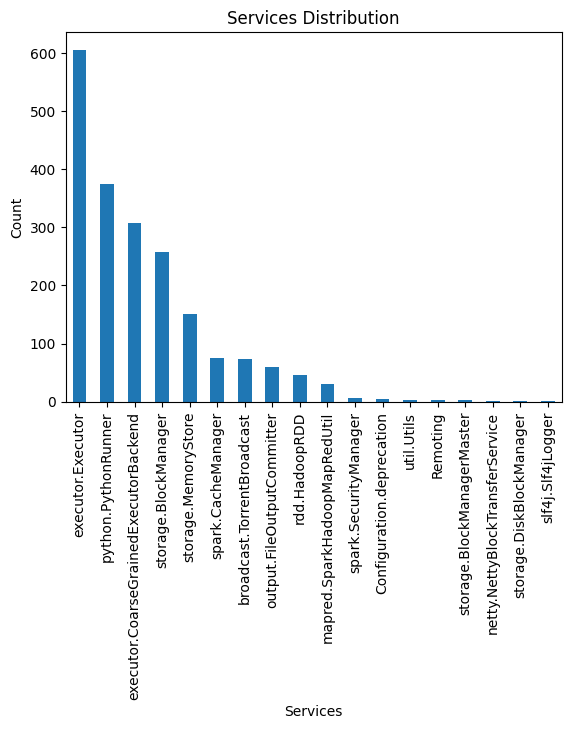

In [19]:
log_level_counts = log_df['service'].value_counts()
log_level_counts.plot(kind='bar')
plt.xlabel('Services')
plt.ylabel('Count')
plt.title('Services Distribution')
plt.show()

Визуализация остальных полей не имеет смысла. Дата и время мало что дадут, а в последнем поле находятся слишком много самых разных сообщений